In [46]:
# Goal: Design simple fit to the absorption line velocity
import sys,os
import numpy as np
import astropy.table as table
import matplotlib.pyplot as plt
import george
from george import kernels
import george.modeling as gmodel
import numba
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
from snelib19odp.specds import load_dataset
import snelib19odp.absfit as absfit
import astropy.constants as aconst
import astropy.units as u

In [2]:
sds = load_dataset('SN2019odp')

/usr/lib/python3/dist-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


In [4]:
C_KM_S = aconst.c.to(u.km/u.s).value

def load_measurements(sds, entry, rev, line):
    fname = sds.get_absfit_path(entry, fit_rev=rev, line=line)
    if not os.path.isfile(fname):
        # TODO: log a warning?
        return None, None
    
    result = absfit.AbsFitResult.load(fname)

    ret = {}

    # ret['logz'] = result.meta['logz']

    for i,label in enumerate(result.parameter_names):
        q = np.quantile(result.trace[:,i], [0.025, 0.5, 0.975, 0.841, 0.159])
        ret['%s_q2.5' % label] = q[0]
        ret['%s_q50' % label] = q[1]
        ret['%s_q97.5' % label] = q[2]
        ret['%s_q84.1' % label] = q[3]
        ret['%s_q15.9' % label] = q[4]

    # extract velocities
    center_idx = result.parameter_names.index('center')

    velocities = (np.array(result.trace[:,center_idx], dtype=np.float) - line)/line * C_KM_S
    label = 'velocity'
    q = np.quantile(velocities, [0.025, 0.5, 0.975, 0.841, 0.159])
    ret['%s_q2.5' % label] = q[0]
    ret['%s_q50' % label] = q[1]
    ret['%s_q97.5' % label] = q[2]
    ret['%s_q84.1' % label] = q[3]
    ret['%s_q15.9' % label] = q[4]

    # extract emission velocites
    em_center_offset_idx = result.parameter_names.index('center_offset_em')

    velocities = (np.array(result.trace[:,center_idx]+result.trace[:, em_center_offset_idx], dtype=np.float) - line)/line * C_KM_S
    label = 'velocity_em'
    q = np.quantile(velocities, [0.025, 0.5, 0.975, 0.841, 0.159])
    ret['%s_q2.5' % label] = q[0]
    ret['%s_q50' % label] = q[1]
    ret['%s_q97.5' % label] = q[2]
    ret['%s_q84.1' % label] = q[3]
    ret['%s_q15.9' % label] = q[4]
    
    # TODO: extract more interesting params
    
    return ret, velocities

In [13]:
rev = 1

rows = []
for line,rev in [(5876, 1), (6678, 2), (7065,1)]:
    for entry in sds.names:
        measurements,velocities = load_measurements(sds, entry, rev, line)
        if measurements is None:
            continue
        measurements['phase'] = sds[entry].meta['phase']
        measurements['line'] = line
        rows.append(measurements)
dat = table.Table(rows=rows)
dat.sort('phase')
dat

<Table length=76>
  continuum_q2.5     continuum_q50    ...        phase         line
     float64            float64       ...       float64       int64
------------------ ------------------ ... ------------------- -----
18.242269797208778  19.09533134707545 ...  -16.83842824074236  5876
10.343117972287502 11.048466811904044 ...  -16.83842824074236  7065
13.793069873901857 14.396346853357796 ...  -16.83842824074236  6678
17.346358290412486 19.596244889055555 ... -15.775404259256902  5876
11.188926767164446 11.977587702208506 ... -15.775404259256902  7065
15.015496388449602 15.441773095446223 ... -15.775404259256902  6678
15.318456128214098 15.575254514587087 ... -15.544725694446242  6678
11.817607594070818  12.54168498459571 ... -15.544725694446242  7065
  17.7847330540256 19.154303796170364 ... -15.544725694446242  5876
29.988126204230724  30.94987559993274 ... -13.822287037037313  5876
               ...                ... ...                 ...   ...
 12.26988165766599 16.761559888361077 ...  104.16555089980102  5876
 3.834722977044179  6.352572922635643 ...  104.16555089980102  6678
15.544504141672652 18.834004922220004 ...  118.14001736111095  6678
14.351045976610923 15.203194054462863 ...  118.14001736111095  5876
14.538440334857718  21.71997820217856 ...  127.85248678240896  6678
13.108252719069625 14.112153863038355 ...  127.85248678240896  5876
12.159728839723604 15.339339044999775 ...  138.22917824074102  6678
10.166977303878234 11.069974468251386 ...  138.22917824074102  5876
1.0007916335477174  1.018848750883087 ...   348.4990856481454  5876
1.1686129470623814    1.6496493686405 ...   348.4990856481454  6678

In [73]:
class Poly2(gmodel.Model):
    parameter_names = ('x0', 'x1', 'x2')
    
    def get_value(self, x):
        return self.x0 + self.x1*x + self.x2*x*x

poly2_pinit = {
    'x0': 5000,
    'x1': 5,
    'x2': 3
}

@numba.njit
def poly2_prior(u):
    x = np.empty_like(u)
    x[0] = 4e4*u[0]-2e4
    x[1] = 1e3*u[1]-500
    x[2] = 200*u[2]-100
    
    # kernel params
    x[3] = 12*u[3]-7
    x[4] = 6*u[4]-3
    return x



In [99]:
idx = dat['phase'] < 40
idx = np.logical_and(idx, dat['amplitude_q2.5'] > 3)
idx = np.logical_and(idx, dat['phase'] > -15.5)
dat2 = dat[idx]
t = dat2['phase']
y = -dat2['velocity_q50']
yerr = np.abs(dat2['velocity_q84.1'] - dat2['velocity_q15.9'])

gp = george.GP(np.var(y) * kernels.Matern32Kernel(30.0), mean=Poly2(**poly2_pinit))
gp.compute(t, yerr)

In [100]:
def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True)

ndim = len(gp.get_parameter_vector())
sampler = dynesty.DynamicNestedSampler(lnprob2, poly2_prior, ndim)
sampler.run_nested()

23495it [03:06, 126.03it/s, batch: 10 | bound: 84 | nc: 1 | ncall: 82688 | eff(%): 28.414 | loglstar: -125.919 < -119.222 < -119.715 | logz: -131.371 +/-  0.201 | stop:  0.960]        


<ErrorbarContainer object of 3 artists>

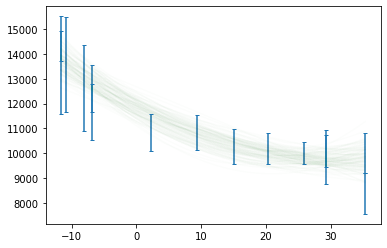

In [101]:
results = sampler.results
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
trace = dyfunc.resample_equal(samples, weights)
t_grid = np.linspace(t.min(), t.max())
for j,sidx in enumerate(np.random.randint(len(trace), size=100)):
    s = trace[sidx]
    gp.set_parameter_vector(s)
    v = gp.sample_conditional(y, t_grid)
    plt.plot(t_grid, v, alpha=0.01, color='green')
plt.errorbar(t, y, yerr=yerr, ls='', capsize=2)

array([ 1.91023960e+00, -1.26834120e+02,  1.17059791e+04])

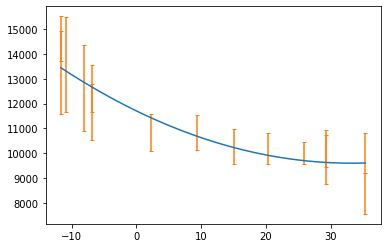

In [102]:
p = np.polyfit(t, y, 2)
t_grid = np.linspace(t.min(), t.max())
plt.plot(t_grid, np.polyval(p, t_grid))
plt.errorbar(t, y, yerr=yerr, ls='', capsize=2)
p

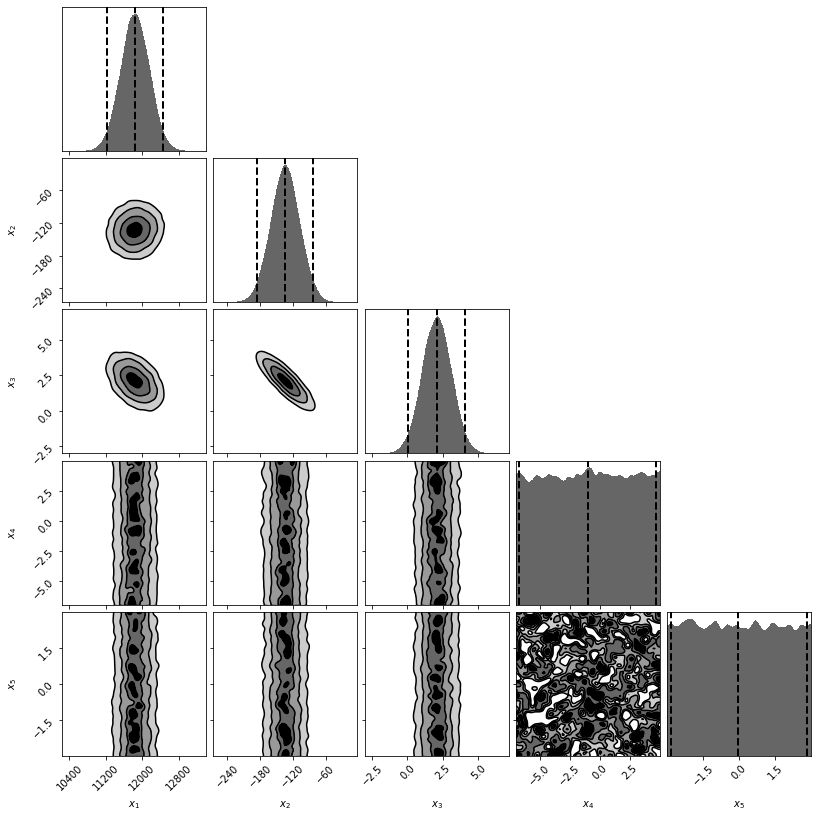

In [103]:
dyplot.cornerplot(results);

In [104]:
gp.get_parameter_names()

('mean:x0',
 'mean:x1',
 'mean:x2',
 'kernel:k1:log_constant',
 'kernel:k2:metric:log_M_0_0')

In [ ]:
dat['amplitude_q50']

(array([  37.,  287., 1389., 4100., 6891., 6293., 3379.,  944.,  156.,
          19.]),
 array([10660.25009305, 10903.65796004, 11147.06582704, 11390.47369403,
        11633.88156103, 11877.28942802, 12120.69729501, 12364.10516201,
        12607.513029  , 12850.920896  , 13094.32876299]),
 <BarContainer object of 10 artists>)

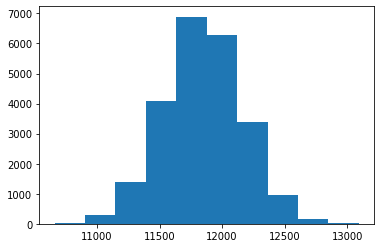

In [105]:
plt.hist(trace[:,0])

In [106]:
np.nanmean(trace[:,0])

11844.642466299469

In [107]:
np.nanstd(trace[:,0])

313.2391337018598